<a href="https://colab.research.google.com/github/jihunyuk/Any/blob/main/CVDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Conplex Valued Deep Neural Network**
# **Hyperparameters**
---
>**Parameter initialization : weight and bias**
---
>**Loss function: ComplexRMSELoss**
---
>**batch size: 23**
---
>**Number of epochs: 6000**
---
>**Number of hidden layers: 2**
---
>**Regularization term parameter: ?**
---
>**Optimization algorithm: Adam**
---
>**learning rate: 0.01**




In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import easydict
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.signal import butter, filtfilt, find_peaks
from scipy import signal
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import *
from random import shuffle
from tqdm.notebook import trange, tqdm
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/gdrive


In [56]:
timesteps = 126
sampling_frequency = 84
batch_size = 22

In [57]:
def cal_fft(x):
    N = 126  # 샘플링 개수
    fs = 84  # 샘플링 주파수
    time = np.arange(N)/fs # 시간

    # FFT 계산
    fft_result = np.fft.fft(x)[:N//2]

    # array 생성
    fft_array = np.zeros(36, dtype=np.complex)

    for i in range(36):
        fft_array[i] = fft_result[i]

    # 6x6 행렬 생성
    fft_matrix = fft_array.reshape(6, 6)

    return fft_matrix

In [58]:
def cal_ifft(fft_matrix):
    fft_array = fft_matrix.reshape(-1)  # 6x6 행렬을 36개의 복소수 값을 가지는 배열로 변환

    N = 126  # 샘플링 개수
    fs = 84  # 샘플링 주파수

    # IFFT 계산을 위한 배열 생성
    ifft_result = np.zeros(N, dtype=np.complex)

    for i in range(36):
        ifft_result[i] = fft_array[i]

    # IFFT 계산
    ifft_result = np.fft.ifft(ifft_result).real.round(3)
    ifft_result = ifft_result - np.min(ifft_result)
    ifft_result = ifft_result / np.max(ifft_result)

    return ifft_result

In [59]:
# -------------------------------------------- load input data & pre-processing -------------------------------------------- #
df_i = []

for i in range(batch_size):
    PPG_data_path = '/content/gdrive/MyDrive/ppg_data/input/input (' + str(i) + ').npy'
    PPG_data = np.load(PPG_data_path)
    PPG_data = np.array(PPG_data).reshape(-1)
    df_i.append(PPG_data)

df_i = np.array(df_i)

PPG_data_i = df_i.reshape(-1,1)

print(PPG_data_i.shape)

print(len(PPG_data_i))
print('The shape of the original dataset is %i by %i' % np.shape(PPG_data_i))

(554400, 1)
554400
The shape of the original dataset is 554400 by 1


[0.30922774 0.30922774 0.30026004 0.30011422 0.30011422 0.30011422
 0.31790381 0.33605794 0.34669443 0.36360912 0.39080385 0.43723824
 0.51105368 0.61215298 0.7323542  0.8263085  0.8558849  0.84006384
 0.76017271 0.66817073 0.55622433 0.44513662 0.34316243 0.24945116
 0.17493094 0.12675486 0.09746199 0.08645286 0.08645286 0.10256556
 0.12071968 0.14214658 0.1512601  0.17619468 0.20447494 0.24186872
 0.27176106 0.29741662 0.33379779 0.34353507 0.35580794 0.36492146
 0.3679836  0.35894299 0.35580794 0.35580794 0.35580794 0.35012111
 0.35580794 0.35223544 0.33656829 0.33656829 0.32745478 0.32745478
 0.32745478 0.34223893 0.34669443 0.34669443 0.34669443 0.34669443
 0.33656829 0.34669443 0.35121473 0.35121473 0.34669443 0.35106891
 0.35099601 0.35157927 0.35996371 0.3598908  0.36893141 0.36492146
 0.36105733 0.35959917 0.36863978 0.39084436 0.44084314 0.53727631
 0.67976313 0.82761274 0.93534668 1.         0.98106008 0.89104283
 0.76486314 0.60734104 0.45266236 0.31637274 0.20797453 0.1248

<ipython-input-57-55a09bebb72d>:10: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fft_array = np.zeros(36, dtype=np.complex)
<ipython-input-58-efc875914140>:8: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ifft_result = np.zeros(N, dtype=np.complex)


<function matplotlib.pyplot.show(close=None, block=None)>

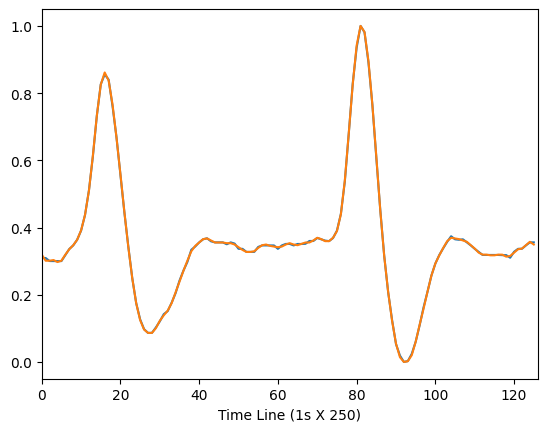

In [60]:
sample = PPG_data_i[0:126,0]
sample = sample - np.min(sample)
sample = sample / np.max(sample)
print(sample)
plt.xlim(0,126)
plt.xlabel('Time Line (1s X 250)')
plt.plot(sample)
print(cal_fft(sample))
print(cal_ifft(cal_fft(sample)))
plt.xlim(0,126)
plt.plot(cal_ifft(cal_fft(sample)))
plt.show

In [61]:
# -------------------------------------------- load target data & pre-processing -------------------------------------------- #
df_t = []

for i in range(batch_size):
    PPG_data_path = '/content/gdrive/MyDrive/ppg_data/target/target (' + str(i) + ').npy'
    PPG_data = np.load(PPG_data_path)
    PPG_data = np.array(PPG_data).reshape(-1)
    df_t.append(PPG_data)

df_t = np.array(df_t)

PPG_data_t = df_t.reshape(-1,1)

print(PPG_data_t.shape)

print(len(PPG_data_t))
print('The shape of the original dataset is %i by %i' % np.shape(PPG_data_t))

(554400, 1)
554400
The shape of the original dataset is 554400 by 1


[[ 4.57164000e+01+0.00000000e+00j -9.51379277e-01+5.11330796e-01j
   3.74622065e+00-6.56355753e+00j  1.25233783e+00+4.56066585e-02j
  -1.07331891e+01-6.89883761e-02j -1.40758264e+00-1.81633084e+00j]
 [ 5.30752865e+00+6.86827185e+00j -1.02325371e+00+2.65794291e+00j
   2.14025841e+00-3.45869391e+00j  1.91100068e+00+2.52267292e-01j
  -2.04790398e+00-9.11180723e-01j -1.43686395e-02-9.86235025e-01j]
 [-5.94704945e-01+1.43829790e+00j -5.47066760e-01+5.28443594e-02j
   6.57704268e-01+3.31197655e-01j -8.98900015e-02+7.18237350e-01j
   2.30125648e-01-2.12571376e-01j  2.93160012e-01+4.80472898e-02j]
 [-5.38877611e-02-1.12646683e-01j -1.03390184e-01-1.83206525e-01j
  -1.01603056e-01+7.19123873e-02j -1.25192000e-01-3.09967813e-02j
   2.05434280e-03+6.39246952e-02j -3.99225964e-02+8.52201754e-02j]
 [ 5.01937826e-02+7.18690813e-02j  2.98012589e-03+4.07512378e-02j
  -4.21626872e-02-2.41175557e-02j -8.04563945e-03+3.38911277e-03j
  -4.70140147e-02+5.93328856e-02j -3.17068336e-03+2.78125504e-02j]
 [-3.

<ipython-input-57-55a09bebb72d>:10: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fft_array = np.zeros(36, dtype=np.complex)
<ipython-input-58-efc875914140>:8: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ifft_result = np.zeros(N, dtype=np.complex)


<function matplotlib.pyplot.show(close=None, block=None)>

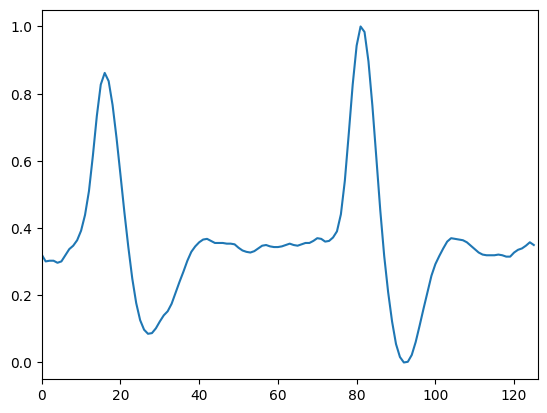

In [62]:
print(cal_fft(PPG_data_i[0:126,0]))
plt.xlim(0,126)
plt.plot(cal_ifft(cal_fft(PPG_data_i[0:126,0])))
plt.show

[[ 3.51542640e+01+0.00000000e+00j -1.12400618e-01+6.84750874e-01j
   3.00055720e-01-1.29975814e+01j  1.84535506e+00-9.43394778e-01j
  -1.27247460e+01-1.21502278e-01j -2.62399640e+00-1.81319819e+00j]
 [ 5.90907720e+00+8.39264911e+00j  4.99321263e-02+2.13333661e+00j
   3.02666665e+00-2.71560940e+00j  1.20400408e+00+4.33186957e-01j
  -9.76883958e-01-2.11302276e+00j  3.87083571e-01-8.09344007e-01j]
 [-8.91504336e-01+2.95616356e-01j -3.33349612e-01-3.03457191e-01j
   1.13868743e-01+3.38676892e-01j -9.94039595e-02+4.70853911e-02j
   1.35888393e-01+3.40130572e-02j  1.24533257e-02+6.34932403e-02j]
 [ 9.75185130e-02-1.29872170e-01j  7.31707580e-02-1.38380097e-02j
  -3.40490779e-03-8.26658824e-02j  2.47360000e-02-5.39568468e-02j
  -1.42594407e-02-1.88845344e-02j  3.48208706e-03-2.70221002e-02j]
 [ 1.07573935e-02+1.39376573e-02j -1.35935199e-02-2.13304432e-03j
   3.24093520e-02-6.87978603e-03j  1.59314299e-02+3.45164393e-03j
   2.82917873e-02+3.67609602e-03j  3.67326200e-02+1.39825120e-03j]
 [ 5.

<ipython-input-57-55a09bebb72d>:10: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fft_array = np.zeros(36, dtype=np.complex)
<ipython-input-58-efc875914140>:8: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ifft_result = np.zeros(N, dtype=np.complex)


<function matplotlib.pyplot.show(close=None, block=None)>

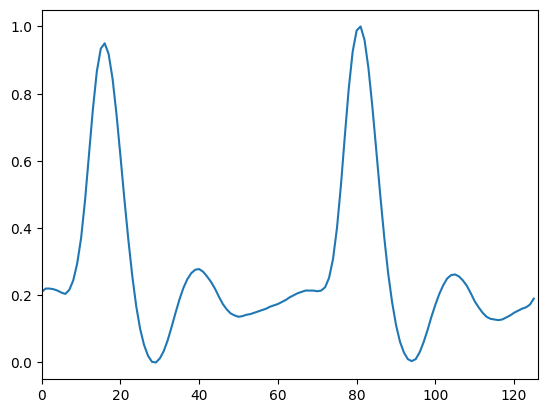

In [63]:
print(cal_fft(PPG_data_t[0:126,0]))
plt.xlim(0,126)
plt.plot(cal_ifft(cal_fft(PPG_data_t[0:126,0])))
plt.show

In [65]:
input_data = []
for i in range(batch_size*200):
  input_data.append(cal_fft(PPG_data_i[126*i:126*i+126,0]))

input_data = torch.tensor(input_data)
print(input_data.shape)

target_data = []
for i in range(batch_size*200):
  target_data.append(cal_fft(PPG_data_t[126*i:126*i+126,0]))

target_data = torch.tensor(target_data)
print(target_data.shape)

<ipython-input-57-55a09bebb72d>:10: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fft_array = np.zeros(36, dtype=np.complex)


torch.Size([4400, 6, 6])
torch.Size([4400, 6, 6])


In [66]:
# 손실 함수 정의
class ComplexRMSELoss(nn.Module): #RME
    def __init__(self):
        super(ComplexRMSELoss, self).__init__()

    def forward(self, input, target):
        real_loss = torch.mean(torch.square(input.real - target.real))
        imag_loss = torch.mean(torch.square(input.imag - target.imag))
        loss = torch.sqrt((real_loss * real_loss + imag_loss * imag_loss)/2)/10
        return loss

# 모델 정의
class CVDNN(nn.Module):
    def __init__(self):
        super(CVDNN, self).__init__()
        self.fc_real = nn.Linear(6, 100)
        self.fc_imag = nn.Linear(6, 100)
        self.fc_hidden1 = nn.Linear(100, 100)
        self.fc_hidden2 = nn.Linear(100, 10)
        self.fc_out_real = nn.Linear(10, 6)
        self.fc_out_imag = nn.Linear(10, 6)
        self.relu = nn.ReLU()

    def forward(self, x):
        x_real = self.fc_real(x.real.double())
        x_real = self.relu(x_real)
        x_real = self.fc_hidden1(x_real)
        x_real = self.relu(x_real)
        x_real = self.fc_hidden2(x_real)
        x_real = self.relu(x_real)
        x_real = self.fc_out_real(x_real)

        x_imag = self.fc_imag(x.imag.double())
        x_imag = self.relu(x_imag)
        x_imag = self.fc_hidden1(x_imag)
        x_imag = self.relu(x_imag)
        x_imag = self.fc_hidden2(x_imag)
        x_imag = self.relu(x_imag)
        x_imag = self.fc_out_imag(x_imag)

        x = torch.complex(x_real, x_imag)

        return x

# 모델 생성
model = CVDNN()
model = model.double()

# 손실 함수 및 최적화
criterion = ComplexRMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# best evaluation 시점의 체크포인트 모델 불러오기기
#model = torch.load('/content/gdrive/MyDrive/checkpoint/checkpoint_best_CVDNN.pt')

# 학습
epochs = 2000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward 단계
    output = model(input_data.unsqueeze(0))
    loss = criterion(output, target_data)

    # Backward 단계
    loss.backward()

    # 매개변수 업데이트
    optimizer.step()
    best_loss = 100000000

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

        if loss.item() < best_loss:
            best_loss = loss.item()
            # best evaluation 시점의 체크포인트 드라이브에 저장
            torch.save(model, '/content/gdrive/MyDrive/checkpoint/checkpoint_best_CVDNN.pt')


# 테스트
test_output = model(input_data.unsqueeze(0))
print("Input Data:")
print(input_data.shape)
print("Predicted Output:")
print(test_output.squeeze().shape)
print("Target Output:")
print(target_data.shape)

Epoch [100/2000], Loss: 0.6578016790548438
Epoch [200/2000], Loss: 0.5848022007169302
Epoch [300/2000], Loss: 0.5373301822833294
Epoch [400/2000], Loss: 0.5076853858359746
Epoch [500/2000], Loss: 0.48257772133426113
Epoch [600/2000], Loss: 0.4669569106083017
Epoch [700/2000], Loss: 0.4567675062567987
Epoch [800/2000], Loss: 0.44841094384700364
Epoch [900/2000], Loss: 0.4409130475432109
Epoch [1000/2000], Loss: 0.43582266624355315
Epoch [1100/2000], Loss: 0.4308841058859244
Epoch [1200/2000], Loss: 0.42495726184945504
Epoch [1300/2000], Loss: 0.41919798109625617
Epoch [1400/2000], Loss: 0.41832048399280364
Epoch [1500/2000], Loss: 0.41730810182740213
Epoch [1600/2000], Loss: 0.40812221316197733
Epoch [1700/2000], Loss: 0.4042028178060482
Epoch [1800/2000], Loss: 0.4048375134417941
Epoch [1900/2000], Loss: 0.412216983415174
Epoch [2000/2000], Loss: 0.3987231195099677
Input Data:
torch.Size([4400, 6, 6])
Predicted Output:
torch.Size([4400, 6, 6])
Target Output:
torch.Size([4400, 6, 6])


Test Input Data:
tensor([[ 4.5716e+01+0.0000e+00j, -9.5138e-01+5.1133e-01j,
          3.7462e+00-6.5636e+00j,  1.2523e+00+4.5607e-02j,
         -1.0733e+01-6.8988e-02j, -1.4076e+00-1.8163e+00j],
        [ 5.3075e+00+6.8683e+00j, -1.0233e+00+2.6579e+00j,
          2.1403e+00-3.4587e+00j,  1.9110e+00+2.5227e-01j,
         -2.0479e+00-9.1118e-01j, -1.4369e-02-9.8624e-01j],
        [-5.9470e-01+1.4383e+00j, -5.4707e-01+5.2844e-02j,
          6.5770e-01+3.3120e-01j, -8.9890e-02+7.1824e-01j,
          2.3013e-01-2.1257e-01j,  2.9316e-01+4.8047e-02j],
        [-5.3888e-02-1.1265e-01j, -1.0339e-01-1.8321e-01j,
         -1.0160e-01+7.1912e-02j, -1.2519e-01-3.0997e-02j,
          2.0543e-03+6.3925e-02j, -3.9923e-02+8.5220e-02j],
        [ 5.0194e-02+7.1869e-02j,  2.9801e-03+4.0751e-02j,
         -4.2163e-02-2.4118e-02j, -8.0456e-03+3.3891e-03j,
         -4.7014e-02+5.9333e-02j, -3.1707e-03+2.7813e-02j],
        [-3.0565e-02+7.3392e-02j, -7.6834e-02+3.7979e-02j,
         -4.2771e-02+7.5586e-02j, 

<ipython-input-58-efc875914140>:8: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ifft_result = np.zeros(N, dtype=np.complex)
<ipython-input-57-55a09bebb72d>:10: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fft_array = np.zeros(36, dtype=np.complex)


<function matplotlib.pyplot.show(close=None, block=None)>

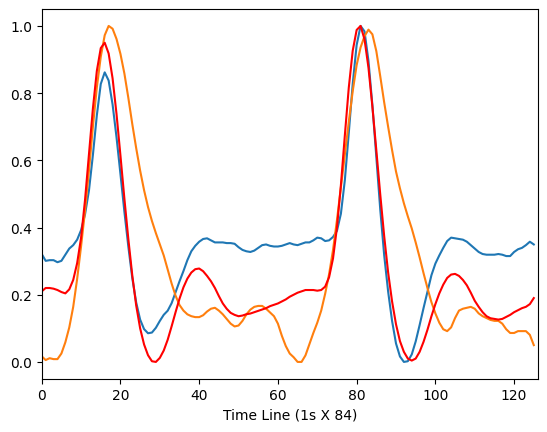

In [67]:
# 테스트 데이터 정의
# test_input_data = torch.tensor([[1.95042254e+02+0.00000000e+00j, 5.97306187e+00-3.48665761e+00j, -4.15126506e+01-2.80030217e+01j, -2.59997402e+00-2.29221227e+00j, 1.50438737e+01+4.80248839e+01j, 3.21887044e-01+1.13902351e+01j],
#                                 [-1.97832436e+01-1.66325740e+01j, 4.26903799e-01-8.63284946e-02j, 7.97646293e+00-1.34770646e+01j, 9.89313124e-01-7.79497309e+00j, -6.76462113e+00+8.58596617e+00j, -4.30645031e+00+2.13244981e+00j],
#                                 [ 3.93337733e+00-3.64327000e+00j, 1.88086866e+00+1.18411888e+00j, -5.95059627e-01+1.36812156e+00j, 1.50083284e+00-1.45316726e+00j, -5.53470656e-01-2.59818942e+00j, -2.01062961e+00-1.64598954e+00j],
#                                 [ 3.04146996e-01+1.60259367e+00j, 1.98173203e-01+1.89476079e+00j, -5.66116805e-01-1.29755808e+00j, 7.81067678e-01-1.09817453e+00j, 9.21017495e-01+7.05619752e-01j, -2.49407173e-01-4.87041974e-01j],
#                                 [-8.01307470e-01-1.17539870e+00j, -6.43716749e-01+1.84299500e-01j, 2.78554711e-01+5.28989825e-01j, 8.84357192e-01+8.97625293e-03j, -1.63172813e-01-1.54852574e-01j, -4.93067943e-01-5.41341393e-01j],
#                                 [ 5.57833244e-01-5.09913114e-01j, 1.78262729e-01+3.37197619e-02j,-8.63511495e-01+1.58721666e-02j, -1.87782871e-01+1.20154923e-02j, 6.64601882e-01+1.24444247e-01j, 2.97823345e-01-2.87068753e-01j]])

test_input_data = torch.tensor([[ 4.57164000e+01+0.00000000e+00j, -9.51379277e-01+5.11330796e-01j, 3.74622065e+00-6.56355753e+00j,  1.25233783e+00+4.56066585e-02j, -1.07331891e+01-6.89883761e-02j, -1.40758264e+00-1.81633084e+00j],
                                [ 5.30752865e+00+6.86827185e+00j, -1.02325371e+00+2.65794291e+00j, 2.14025841e+00-3.45869391e+00j,  1.91100068e+00+2.52267292e-01j, -2.04790398e+00-9.11180723e-01j, -1.43686395e-02-9.86235025e-01j],
                                [-5.94704945e-01+1.43829790e+00j, -5.47066760e-01+5.28443594e-02j, 6.57704268e-01+3.31197655e-01j, -8.98900015e-02+7.18237350e-01j, 2.30125648e-01-2.12571376e-01j,  2.93160012e-01+4.80472898e-02j],
                                [-5.38877611e-02-1.12646683e-01j, -1.03390184e-01-1.83206525e-01j, -1.01603056e-01+7.19123873e-02j, -1.25192000e-01-3.09967813e-02j, 2.05434280e-03+6.39246952e-02j, -3.99225964e-02+8.52201754e-02j],
                                [ 5.01937826e-02+7.18690813e-02j,  2.98012589e-03+4.07512378e-02j, -4.21626872e-02-2.41175557e-02j, -8.04563945e-03+3.38911277e-03j, -4.70140147e-02+5.93328856e-02j, -3.17068336e-03+2.78125504e-02j],
                                [-3.05647322e-02+7.33915538e-02j, -7.68340845e-02+3.79791839e-02j, -4.27713349e-02+7.55863168e-02j, -7.83351152e-03+2.12743640e-02j, 3.39653002e-02+2.31531603e-02j, -7.15244446e-02+5.21809420e-02j]])


# 모델 예측
model.eval()
with torch.no_grad():
    test_output = model(test_input_data.unsqueeze(0))

# 결과 출력
print("Test Input Data:")
print(test_input_data)
print("Predicted Output:")
print(test_output.squeeze())

# 결과 플롯팅
plt.xlim(0,126)
plt.xlabel('Time Line (1s X 84)')
plt.plot(cal_ifft(test_input_data))
plt.plot(cal_ifft(test_output.squeeze()))
plt.plot(cal_ifft(cal_fft(PPG_data_t[0:126,0])), color = 'r')
plt.savefig("temp", dpi=300)
plt.show

<ipython-input-57-55a09bebb72d>:10: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fft_array = np.zeros(36, dtype=np.complex)


Test Input Data:
tensor([[ 1.0464e+04+0.0000j,  2.9152e+02-462.6187j, -6.2418e+01-249.7053j,
          1.6296e+01-202.3394j, -5.7187e+01-110.9853j,  1.3765e+02-70.5398j],
        [ 7.1365e+01-147.3974j, -6.8031e+01-50.8707j,  1.7419e+01-14.7718j,
          5.3752e+01+91.4507j,  1.2921e+02+17.8591j,  2.6502e+01-146.4886j],
        [-3.9935e+00-211.5194j, -4.0045e+01-138.2753j, -7.8063e+00-89.0875j,
         -1.6386e+01-4.9343j,  1.9833e+01-52.3875j, -5.3774e+01-144.5497j],
        [-9.0209e+01-57.2805j, -1.3420e+02+2.2929j,  5.2727e+00+37.3527j,
          2.0438e+01+30.1223j, -8.0288e+01-6.4589j, -5.3987e+00-83.6215j],
        [ 1.2380e+01+6.9898j, -4.0895e+01-73.1648j, -1.7558e+00+11.5204j,
          2.0067e+01-41.7541j, -1.6278e+01-23.5679j, -3.4599e+01-85.8093j],
        [ 2.6829e+01-139.4210j, -3.8731e+01-41.0702j, -1.2475e+02+29.7595j,
         -2.5615e+01-35.1979j, -4.3827e+01+72.3596j, -9.5439e+00+27.6052j]],
       dtype=torch.complex128)
Predicted Output:
tensor([[ 2.3124e+03-7

<ipython-input-58-efc875914140>:8: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ifft_result = np.zeros(N, dtype=np.complex)


<function matplotlib.pyplot.show(close=None, block=None)>

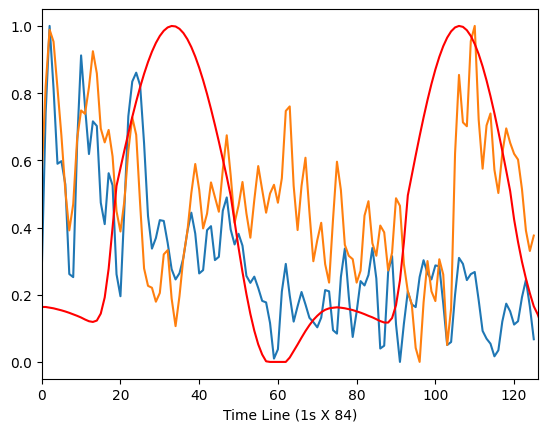

In [113]:
# 검증 데이터 정의
df_i_test = []
df_t_test = []

list_p = [22]
for i in list_p:
    PPG_data_path = '/content/gdrive/MyDrive/ppg_data/input/input (' + str(i) + ').npy'
    PPG_data = np.load(PPG_data_path)
    PPG_data = np.array(PPG_data).reshape(-1)
    df_i_test.append(PPG_data)

for i in list_p:
    PPG_data_path = '/content/gdrive/MyDrive/ppg_data/target/target (' + str(i) + ').npy'
    PPG_data = np.load(PPG_data_path)
    PPG_data = np.array(PPG_data).reshape(-1)
    df_t_test.append(PPG_data)

df_i_test = np.array(df_i_test[:126])

df_i_test = df_i_test.reshape(-1,1)
test_input_data = torch.tensor(cal_fft(df_i_test[:,0]))


# 모델 예측
model.eval()
with torch.no_grad():
    test_output = model(test_input_data.unsqueeze(0))

# 결과 출력
print("Test Input Data:")
print(test_input_data)
print("Predicted Output:")
print(test_output.squeeze())

# 결과 플롯팅
plt.xlim(0,126)
plt.xlabel('Time Line (1s X 84)')
plt.plot(cal_ifft(test_input_data))
plt.plot(cal_ifft(test_output.squeeze()))
plt.plot(df_t_test[0], color = 'r')
plt.savefig("temp", dpi=300)
plt.show

In [112]:
# 심박수 호흡수 출력 함수 정의
def cal_rate(x):
    N = 126  # 샘플링 개수
    fs =84  # 샘플링 주파수
    time = np.arange(N)/fs # 시간

    # 심박 관련 주파수 대역 계산
    pulse_freq_range = [0.67, 3.33]  # 대역 범위
    idx_min_p = int(np.floor(pulse_freq_range[0] * N / fs))  # 최소 주파수에 해당하는 FFT 인덱스
    idx_max_p = int(np.ceil(pulse_freq_range[1] * N / fs))  # 최대 주파수에 해당하는 FFT 인덱스

    # 호흡 관련 주파수 대역 계산
    resp_freq_range = [0.13, 0.33]  # 대역 범위
    idx_min_r = int(np.floor(resp_freq_range[0] * N / fs))  # 최소 주파수에 해당하는 FFT 인덱스
    idx_max_r = int(np.ceil(resp_freq_range[1] * N / fs))  # 최대 주파수에 해당하는 FFT 인덱스

    # 심박 IFFT 계산
    fft = np.fft.fft(x)
    fft[:idx_min_p] = 0  # 주파수 대역 이외의 FFT 계수는 0으로 설정
    fft[idx_max_p+1:] = 0
    pulse_filtered = np.real(np.fft.ifft(fft))  # IFFT 계산 후 실수 부분만 추출

    # 호흡 IFFT 계산
    fft1 = np.fft.fft(x)
    fft1[0]=0
    fft1[0:idx_min_r] = 0  # 주파수 대역 이외의 FFT 계수는 0으로 설정
    fft1[idx_max_r+1:] = 0
    resp_filtered1 = np.real(np.fft.ifft(fft1))  # IFFT 계산 후 실수 부분만 추출

    # 심박수 계산
    peak_indices, _ = find_peaks(pulse_filtered, height = 0.1, distance=30)
    peak_times = time[peak_indices]

    pp_intervals = np.diff(peak_times)
    bpm_p = 60 / pp_intervals.mean()
    print("분당 심박수: ", bpm_p)

    # 호흡수 계산
    peak_indices1, _ = find_peaks(resp_filtered1)
    peak_times = time[peak_indices]
    inv_resp_filtered1 = resp_filtered1*(-1)
    peak_indices2, _ = find_peaks(inv_resp_filtered1)
    rr_intervals = np.abs(peak_indices2 - peak_indices1)
    bpm_r = float(60 / rr_intervals)
    print("분당 호흡수: ", bpm_r*60)

    # 결과 출력
    plt.plot(x, label='Original PPG Signal')
    plt.plot(pulse_filtered, label='Pulse Signal')
    plt.plot(resp_filtered1*5, label='Respiration Signal')
    plt.xlim(0, 126)
    plt.xlabel('Time Line (1s X 250)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.savefig("temp", dpi=300)
    plt.show()

<ipython-input-58-efc875914140>:8: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ifft_result = np.zeros(N, dtype=np.complex)


분당 심박수:  93.33333333333334
분당 호흡수:  57.14285714285714


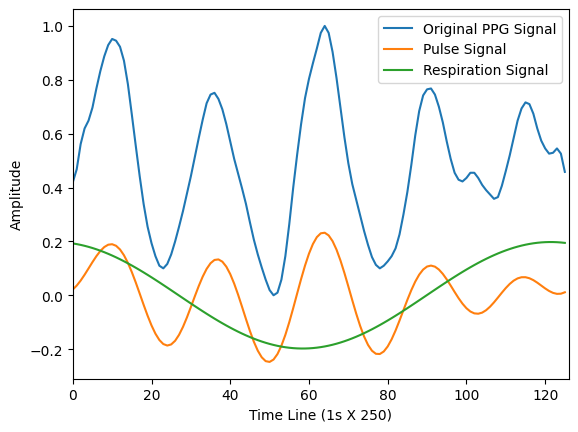

In [91]:
# 예측 PPG 신호의 분당 심박수 & 호흡수 출력
cal_rate(cal_ifft(test_output.squeeze()).reshape(-1))

<ipython-input-90-29dbdfbbb6d8>:35: RuntimeWarning: Mean of empty slice.
  bpm_p = 60 / pp_intervals.mean()


분당 심박수:  nan
분당 호흡수:  0.28571428571428575


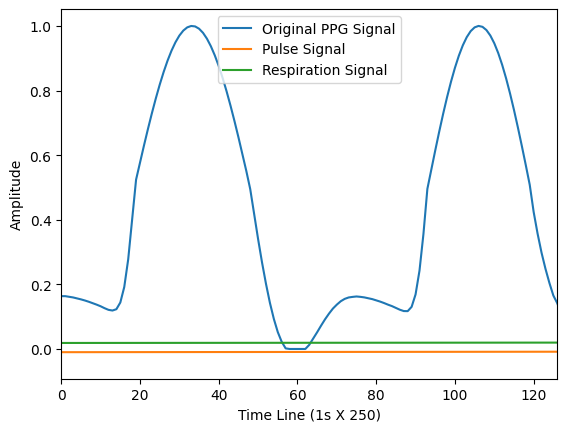

In [92]:
# 동시간 적정 압력 PPG 신호의 분당 심박수 & 호흡수 출력
cal_rate(df_t_test[0].reshape(-1))